In [602]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

## Global parameters setup

Executing methods that do some data transformation which involves randomness (i.e. sampling or data splitting) yields different result for each run. In order to have predictable results we can leverage the function argument called `random_state` and set it to a constant value (`randomness_id`).

In [603]:
# @formatter:off
%matplotlib inline
# %matplotlib notebook
# @formatter:on
randomness_id = 5100
np.random.seed(randomness_id)

In [604]:
df = pd.read_csv("./data/Video_Games_Sales_as_at_22_Dec_2016.csv")
df.shape

(16719, 16)

In [605]:
df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [606]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       10015 non-null  object 
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


In [607]:
df["Year_of_Release"] = pd.to_numeric(df["Year_of_Release"], errors='coerce').astype('int64', errors="ignore")
df["User_Score"] = pd.to_numeric(df["User_Score"], errors='coerce')
print(f"There are {df.isnull().any(axis=1).sum()} rows with missing data.")
print(f"There are {df.isnull().sum().sum()} missing data fields within these rows.")
df.isnull().sum()

There are 9894 rows with missing data.
There are 49141 missing data fields within these rows.


Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher            54
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8582
Critic_Count       8582
User_Score         9129
User_Count         9129
Developer          6623
Rating             6769
dtype: int64

In [608]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       7590 non-null   float64
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(10), object(6)
memory usage: 2.0+ MB


In [609]:
df = df[df["Name"].notna() & df["Year_of_Release"].notna() & df["Publisher"].notna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16416 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16416 non-null  object 
 1   Platform         16416 non-null  object 
 2   Year_of_Release  16416 non-null  float64
 3   Genre            16416 non-null  object 
 4   Publisher        16416 non-null  object 
 5   NA_Sales         16416 non-null  float64
 6   EU_Sales         16416 non-null  float64
 7   JP_Sales         16416 non-null  float64
 8   Other_Sales      16416 non-null  float64
 9   Global_Sales     16416 non-null  float64
 10  Critic_Score     7982 non-null   float64
 11  Critic_Count     7982 non-null   float64
 12  User_Score       7461 non-null   float64
 13  User_Count       7461 non-null   float64
 14  Developer        9904 non-null   object 
 15  Rating           9767 non-null   object 
dtypes: float64(10), object(6)
memory usage: 2.1+ MB


In [610]:
df.nunique(dropna=True)

Name               11397
Platform              31
Year_of_Release       39
Genre                 12
Publisher            579
NA_Sales             401
EU_Sales             307
JP_Sales             244
Other_Sales          155
Global_Sales         628
Critic_Score          81
Critic_Count         106
User_Score            95
User_Count           883
Developer           1680
Rating                 8
dtype: int64

In [611]:
df.describe()

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,16416.000000,16416.000000,16416.000000,16416.000000,16416.000000,16416.000000,7982.000000,7982.000000,7461.000000,7461.000000
mean,2006.489888,0.264129,0.146034,0.078623,0.047670,0.536708,68.997119,26.440992,7.126900,163.008846
std,5.881148,0.819028,0.507134,0.311348,0.188156,1.559885,13.918755,19.009305,1.498886,563.932422
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,0.000000,4.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000,60.000000,12.000000,6.400000,10.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000,71.000000,22.000000,7.500000,24.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,0.470000,79.000000,36.000000,8.200000,81.000000
max,2020.000000,41.360000,28.960000,10.220000,10.570000,82.530000,98.000000,113.000000,9.700000,10665.000000


<AxesSubplot:>

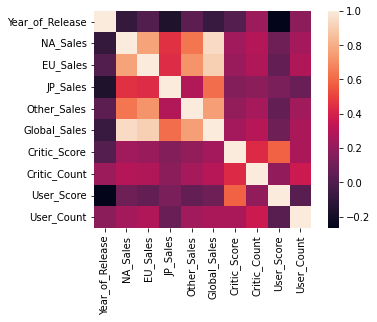

In [612]:
sns.heatmap(df.corr(), square=True)

In [613]:
pure_df = df[df.notna().all(axis=1)]
print(pure_df.shape)
pure_df.info()

(6825, 16)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6825 entries, 0 to 16706
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             6825 non-null   object 
 1   Platform         6825 non-null   object 
 2   Year_of_Release  6825 non-null   float64
 3   Genre            6825 non-null   object 
 4   Publisher        6825 non-null   object 
 5   NA_Sales         6825 non-null   float64
 6   EU_Sales         6825 non-null   float64
 7   JP_Sales         6825 non-null   float64
 8   Other_Sales      6825 non-null   float64
 9   Global_Sales     6825 non-null   float64
 10  Critic_Score     6825 non-null   float64
 11  Critic_Count     6825 non-null   float64
 12  User_Score       6825 non-null   float64
 13  User_Count       6825 non-null   float64
 14  Developer        6825 non-null   object 
 15  Rating           6825 non-null   object 
dtypes: float64(10), object(6)
memory usage: 906.4+ K

In [614]:
pure_df.describe()

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000
mean,2007.436777,0.394484,0.236089,0.064158,0.082677,0.777590,70.272088,28.931136,7.185626,174.722344
std,4.211248,0.967385,0.687330,0.287570,0.269871,1.963443,13.868572,19.224165,1.439942,587.428538
min,1985.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,0.500000,4.000000
25%,2004.000000,0.060000,0.020000,0.000000,0.010000,0.110000,62.000000,14.000000,6.500000,11.000000
50%,2007.000000,0.150000,0.060000,0.000000,0.020000,0.290000,72.000000,25.000000,7.500000,27.000000
75%,2011.000000,0.390000,0.210000,0.010000,0.070000,0.750000,80.000000,39.000000,8.200000,89.000000
max,2016.000000,41.360000,28.960000,6.500000,10.570000,82.530000,98.000000,113.000000,9.600000,10665.000000


In [615]:
preprocessor = Pipeline(
    [
        ("scaler", StandardScaler()),
    ]
)

clusterer = Pipeline(
    [
        (
            "kmeans",
            KMeans(
                n_clusters=2,
                init="k-means++",
                n_init=50,
                max_iter=500,
                random_state=randomness_id,
            ),
        ),
    ]
)

pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)


def remove_outliers(df, col_name):
    q_low = df[col_name].quantile(0.05)
    q_hi = df[col_name].quantile(0.95)
    return df[(df[col_name] > q_low) & (df[col_name] < q_hi)]

In [616]:
sales_user = pure_df[["NA_Sales", "User_Score"]].sample(frac=0.1, random_state=randomness_id)

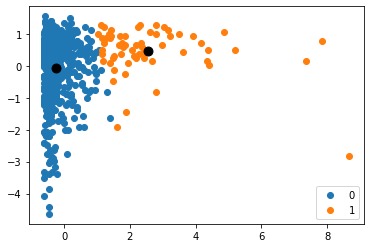

In [617]:
labels = pipe.fit_predict(sales_user)
centroids = pipe["clusterer"]["kmeans"].cluster_centers_
u_labels = np.unique(labels)

scaled_df = pipe["preprocessor"]["scaler"].transform(sales_user)
for i in u_labels:
    plt.scatter(scaled_df[labels == i, 0], scaled_df[labels == i, 1], label=i)
plt.scatter(centroids[:, 0], centroids[:, 1], s=80, color='k')
plt.legend()
plt.show()

In [618]:
sales_user_no_outliers = remove_outliers(sales_user, "NA_Sales")
sales_user_no_outliers.describe()

,NA_Sales,User_Score
count,578.000000,578.000000
mean,0.276125,7.248443
std,0.294435,1.423523
min,0.010000,0.600000
25%,0.080000,6.500000
50%,0.170000,7.600000
75%,0.360000,8.300000
max,1.440000,9.500000


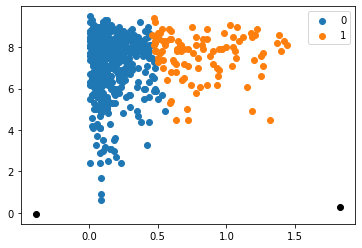

In [619]:
labels = pipe.fit_predict(sales_user_no_outliers)
centroids = pipe["clusterer"]["kmeans"].cluster_centers_
u_labels = np.unique(labels)

for i in u_labels:
    plt.scatter(sales_user_no_outliers.values[labels == i, 0], sales_user_no_outliers.values[labels == i, 1], label=i)
plt.scatter(centroids[:, 0], centroids[:, 1], color='k')
plt.legend()
plt.show()